**author**: lukethompson@gmail.com<br>
**date**: 17 Dec 2017<br>
**language**: Python 3.5<br>
**license**: BSD3<br>

## trading_cards_2_macros_figures.ipynb

Generate LaTeX macros and figures for a 'trading card' for any given Deblur OTU (sOTU or tag sequence).

### Settings and input files

In [1]:
import pandas as pd
import numpy as np
import biom
import wikipedia
import re
import os
import errno
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# seaborn plot settings
sns.set(style='white', palette='muted', color_codes=True)
sns.set_context('talk', rc={"font.size":13,"axes.titlesize":13,"axes.labelsize":13})
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
# input
path_map = '/Users/luke.thompson/agp/manuscript-package-20170512/1250/ag_map_with_alpha.txt'
path_biom = '/Users/luke.thompson/agp/manuscript-package-20170512/1250/deblur_125nt_no_blooms_rare.biom'
path_otus = 'deblur_125nt_no_blooms_rare.seq_summary.tsv'
trim_length = 125
rarefaction_depth = 1250

# output
path_output = 'latex'

### Functions

In [4]:
def make_directory(path):
    """Make directory if doesn't already exist"""
    try:
        os.mkdir(path)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise exc
        pass

In [5]:
def get_wikipedia(my_taxonomy):
    """Get wikipedia entry for genus or higher (lowest taxonomic level that begins (position 3) 
    with capital letter)
    """
    for level in reversed(my_taxonomy.split('; ')):
        if len(level) > 3:
            if level[3].isupper():
                title = level[3:]
                print(title)
                try:
                    entry = wikipedia.page(title)
                    return('%s\t%s' % (title, entry.summary))
                except wikipedia.exceptions.DisambiguationError as e:
                    return('%s\t%s has multiple options: %s' % (title, title, e.options))
                except wikipedia.exceptions.PageError as e:
                    return('%s\t%s has no Wikipedia page.' % (title, title))
                break

In [6]:
def make_point_plot(row, df, category, figpath):
    """Make pointplot given these inputs:
        row - occurrence information for one sequence (row in df_otus, imported from *.seq_summary.tsv)
        df - metadata dataframe
        category - metadata category
    """
    category_count_all = df[category].value_counts()

    for index, row in df_otus_top.iloc[[0]].iterrows():
        category_count_sequence = df.loc[row['list_samples'].split(',')][category].value_counts()
        df_pointplot_data = pd.concat([category_count_all/category_count_all.sum(), 
                                       category_count_sequence/category_count_sequence.sum()], axis=1)
        df_pointplot_data.columns = ['count_all', 'count_sequence']
        df_pointplot_data[category] = df_pointplot_data.index
        df_pointplot_data_melted = pd.melt(df_pointplot_data, id_vars=[category],
                                           value_vars=['count_all', 'count_sequence'])
        
        fig, ax = plt.subplots(figsize=(2.5,4))
        sns.pointplot(x='variable', y='value', hue=category, data=df_pointplot_data_melted)
        plt.xlabel('')
        plt.xticks([0, 1], ('All\nsamples', 'Samples\ncontaining\nsequence'))
        plt.ylabel('Relative distribution', fontsize=12)
        plt.box('off')
        sns.despine(offset=10, trim=True)
        plt.legend(bbox_to_anchor=(1,1), title=category)
        plt.savefig(figpath, bbox_inches='tight')

In [7]:
def scatter_map(table, samples, seq):
    """Make dataframe of a given otu with metadata"""
    otu_count = table.data(id=seq, axis='observation')
    df_otu = pd.DataFrame(data=otu_count, index=samples, columns=['otu'])
    df_otu_map = pd.merge(df_map, df_otu, left_index=True, right_index=True)
    # must remove zero counts otherwise scatter plot is misleading
    df_otu_map.otu = [np.nan if x==0 else x for x in df_otu_map.otu]
    return(df_otu_map)

### Section 1: Read input tables

In [8]:
# read mapping file
df_map = pd.read_csv(path_map, sep='\t', index_col=0, low_memory=False)
# read otu summary
df_otus = pd.read_csv(path_otus, sep='\t', index_col=0)
# read biom table
table = biom.load_table(path_biom)
# biom table properties
otus = table.ids(axis='observation')
samples = table.ids(axis='sample')
num_samples = samples.shape[0]

### Section 2: Make the OTU lists

#### Top metadata categories ordered by unweighted effect size (largest to smallest)

In [9]:
top_cat = ['age_cat', 'center_project_name', 'antibiotic_history', 'processing_robot', 'prepared_meals_frequency', 
           'race', 'salted_snacks_frequency', 'sugary_sweets_frequency', 'country', 'longitude', 
           'fruit_frequency', 'collection_month', 'types_of_plants', 'latitude', 'fungal_overgrowth',
           'bowel_movement_frequency', 'drinks_per_session', 'vioscreen_caffeine', 'primer_plate', 'probiotic_frequency']

#### Option 1: Top OTUs by num_samples

In [10]:
df_otus_top_prev = df_otus.sort_values('num_samples', ascending=False).head(10)

In [11]:
df_otus_top_prev[['sequence', 'num_samples', 'num_samples_frac', 'num_samples_rank',
            'total_obs', 'total_obs_frac', 'total_obs_rank', 'taxonomy']].to_csv('deblur_125nt_no_blooms_rare.top10_prevalence.tsv')

#### Option 2: Top OTUs by total_obs

In [12]:
df_otus_top_abund = df_otus.sort_values('total_obs', ascending=False).head(10)

In [13]:
df_otus_top_abund[['sequence', 'num_samples', 'num_samples_frac', 'num_samples_rank',
       'total_obs', 'total_obs_frac', 'total_obs_rank', 'taxonomy']].to_csv('deblur_125nt_no_blooms_rare.top10_abundance.tsv')

#### Option 3: Manually pick OTUs

Here: Most prevalent, most abundant, and S24-7 (most prevalent of S24.7)

In [14]:
manual_seqs = list(df_otus[df_otus.num_samples_rank == 1]['sequence']) + list(
    df_otus[df_otus.total_obs_rank == 1]['sequence']) + [
    df_otus[['S24-7' in tax for tax in df_otus.taxonomy]].iloc[0, :]['sequence']]

In [15]:
df_otus_manual = df_otus[df_otus['sequence'].isin(manual_seqs)]

#### Then store chosen dataframe as df_otus_top

In [16]:
df_otus_top = df_otus_manual

### Section 3. Make the trading cards

#### Look up Wikipedia information

In [17]:
# add wikipedia summary
df_otus_top.loc[:,'wikipedia'] = df_otus_top['taxonomy'].apply(get_wikipedia)
df_otus_top.loc[:,'title'] = [value.split('\t')[0] for value in df_otus_top['wikipedia']]
df_otus_top.loc[:,'wikipedia'] = [value.split('\t')[1] for value in df_otus_top['wikipedia']]

Faecalibacterium
Bacteroides
S24-7


/Users/luke.thompson/miniconda3/envs/emp-py3/lib/python3.5/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/luke.thompson/miniconda3/envs/emp-py3/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
# use only first OTU for testing purposes
#df_otus_top.iloc[[0]]

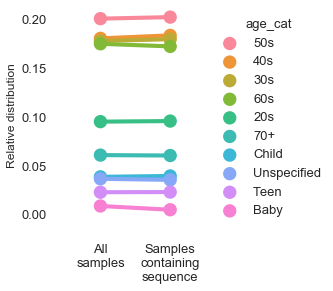

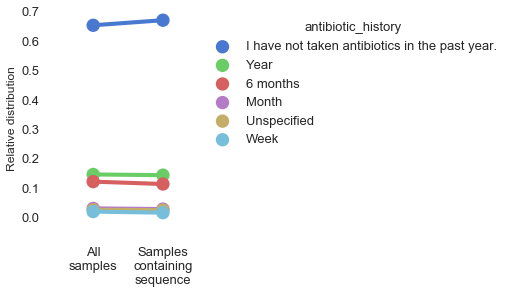

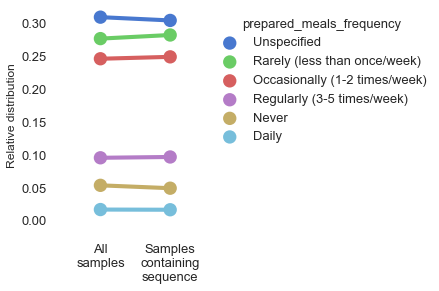

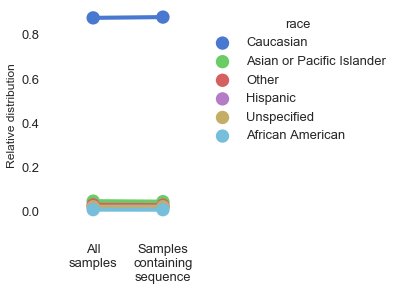

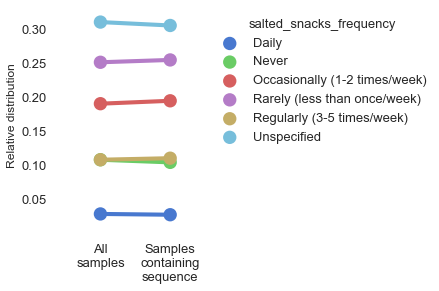

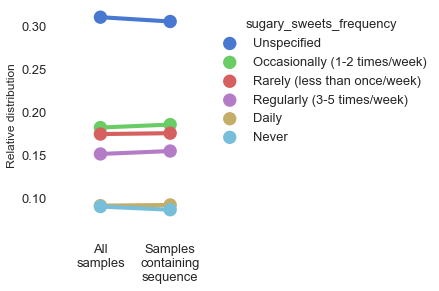

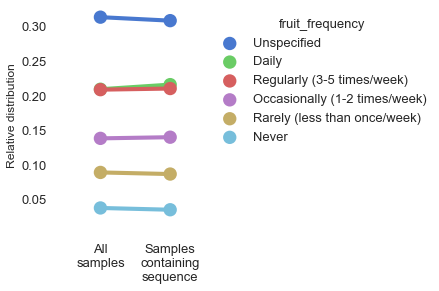

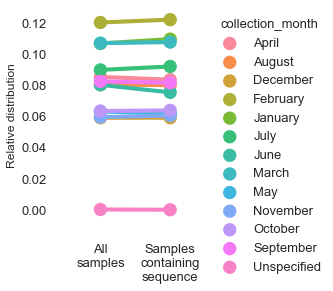

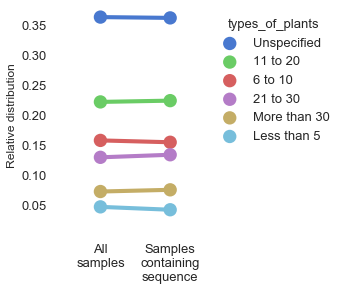

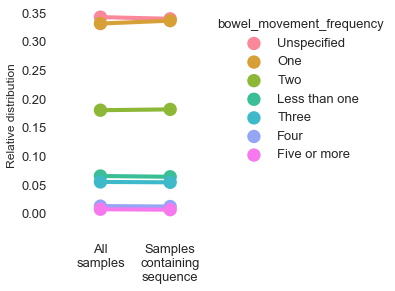

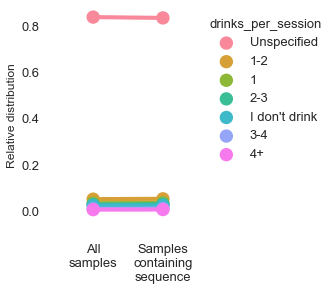

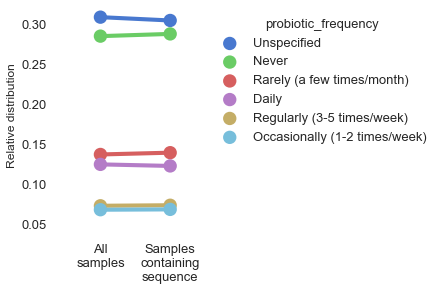

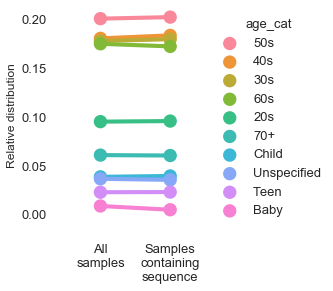

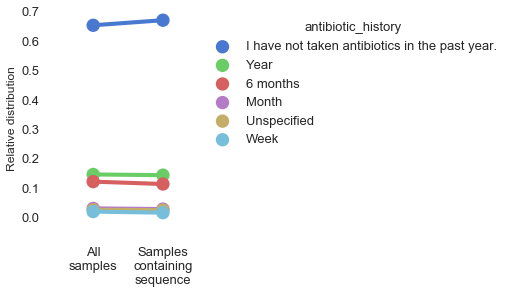

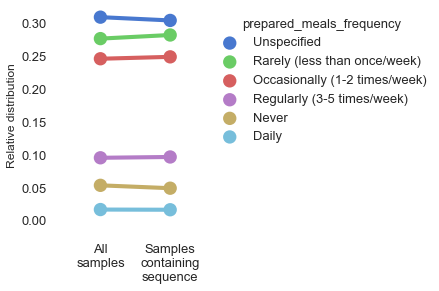

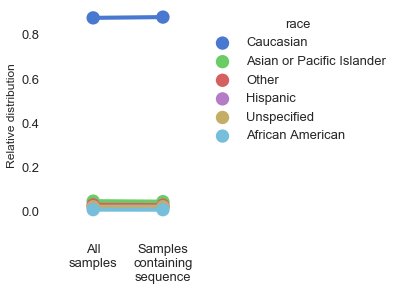

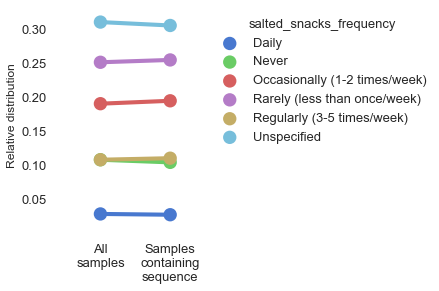

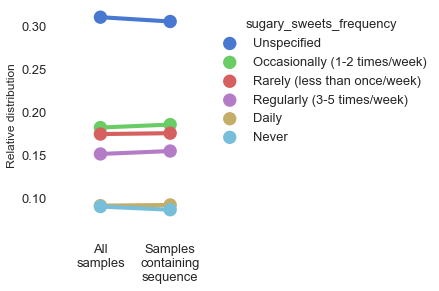

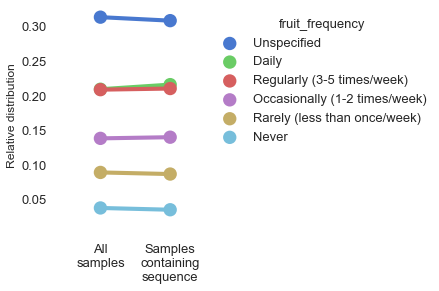

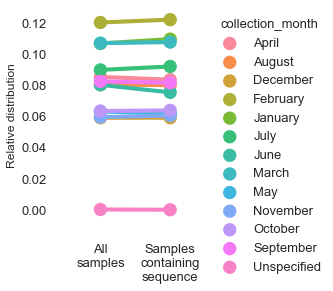

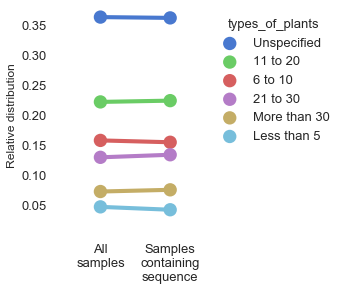

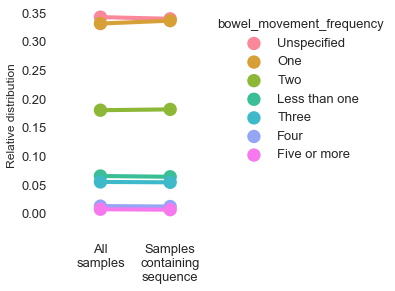

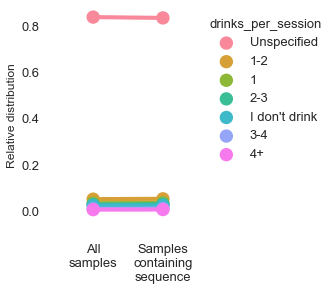

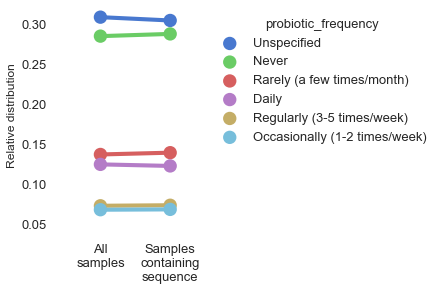

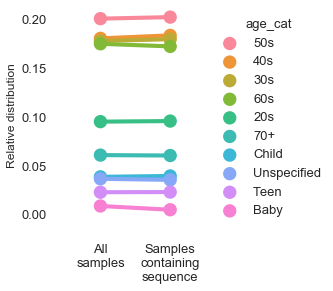

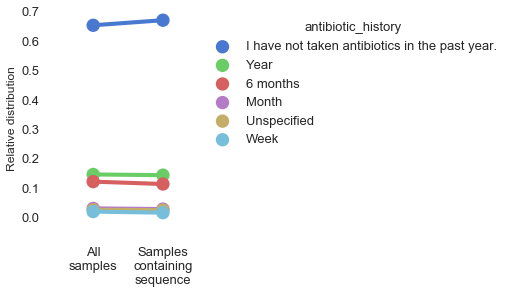

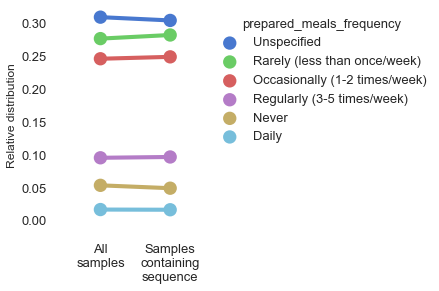

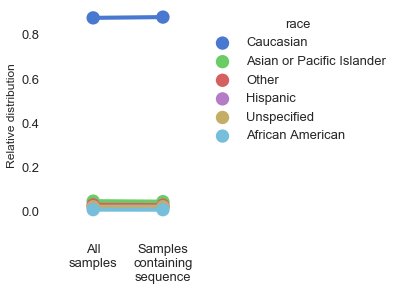

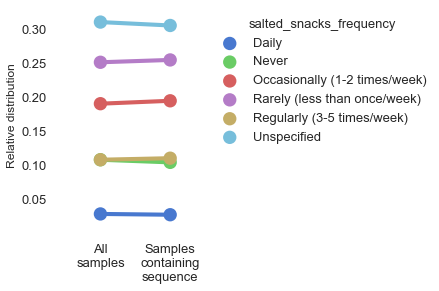

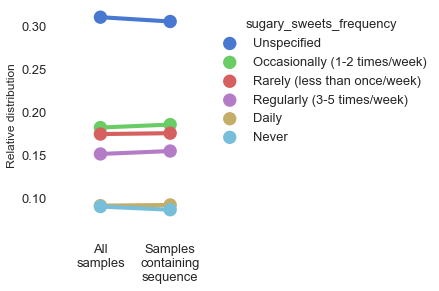

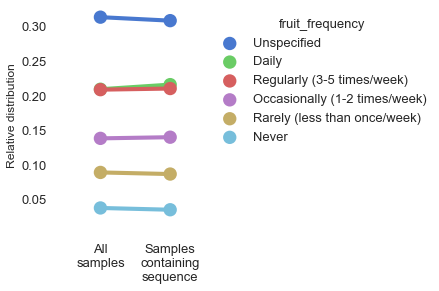

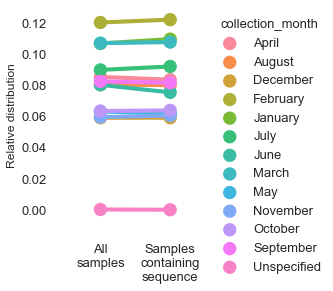

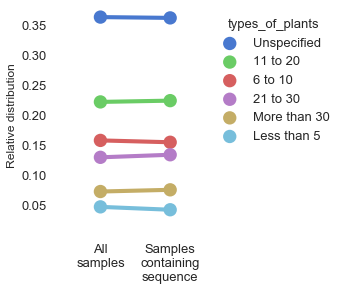

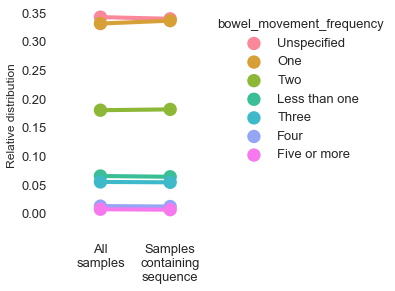

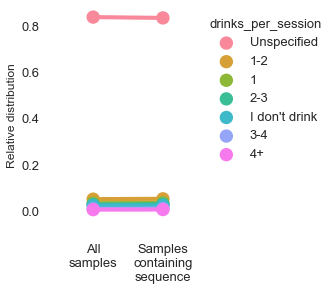

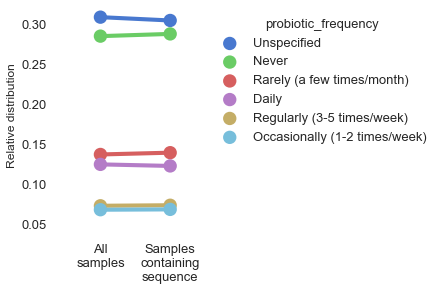

In [19]:
for index, row in df_otus_top.iterrows():
    
    # STORE THE RELEVANT VALUES
    sequence = row['sequence']
    taxonomy_gg = re.sub(r'_', r'\_', row['taxonomy'])
    wikipedia = row['wikipedia']
    wikipedia = re.sub(r'"', r'``', wikipedia)
    wikipedia = re.sub(u'\u201D', r"''", wikipedia) # need to replace unicode backward double quote
    title = row['title']
    #title = sequence
    prevalencePercent = row['num_samples_frac'] * 100
    prevalenceRank = str(row['num_samples_rank'])
    abundancePercent = row['total_obs_frac'] * 100
    abundanceRank = str(row['total_obs_rank'])
    numOTUs = str(df_otus.shape[0])
    numSamples = str(num_samples)
    trimLength = str(trim_length)
    rarefactionDepth = str(rarefaction_depth)

    # MAKE DIRECTORY
    new_directory = '%s/card_%sbp_rare%s_rank%s_%s' % (path_output, 
            trimLength, rarefactionDepth, prevalenceRank, title)
    make_directory(new_directory)
    
    # CREATE MACROS FILE
    with open('%s/macros.tex' % new_directory, 'w') as target:
        # SEQUENCE
        target.write(r'\def\sequence{')
        # first 50bp
        target.write(sequence[:50])
        # next 50bp
        target.write('\n')
        target.write(sequence[50:100])
        # next 50bp if > 100bp
        if len(sequence) > 100:
            target.write('\n')
            target.write(sequence[100:150])
        target.write('}\n')
        # TAXONOMY
        target.write(r'\def\taxonomyGG{')
        target.write(taxonomy_gg)
        target.write('}\n')
        # WIKIPEDIA
        target.write(r'\def\wikipedia{')
        if len(wikipedia) > 650:
           target.write(wikipedia[:650])
           target.write('...')
        else:
           target.write(wikipedia)
        target.write('}\n')
        # PREVALENCE
        target.write(r'\def\prevalencePercent{')
        target.write('{:0.2f}'.format(prevalencePercent))
        target.write('}\n')
        target.write(r'\def\prevalenceRank{')
        target.write(prevalenceRank)
        target.write('}\n')
        # ABUNDANCE
        target.write(r'\def\abundancePercent{')
        target.write('{:0.3f}'.format(abundancePercent))
        target.write('}\n')
        target.write(r'\def\abundanceRank{')
        target.write(abundanceRank)
        target.write('}\n')
        # METHODS/MISC
        target.write(r'\def\numOTUs{')
        target.write(numOTUs)
        target.write('}\n')
        target.write(r'\def\trimLength{')
        target.write(trimLength)
        target.write('}\n')
        target.write(r'\def\numSamples{')
        target.write(numSamples)
        target.write('}\n')
        target.write(r'\def\rarefactionDepth{')
        target.write(rarefactionDepth)
        target.write('}\n')
        
    # POINT PLOT OF PRESENCE/ABSENCE
    for category in ['age_cat', 'antibiotic_history', 'prepared_meals_frequency', 
               'race', 'salted_snacks_frequency', 'sugary_sweets_frequency',  
               'fruit_frequency', 'collection_month', 'types_of_plants', 
               'bowel_movement_frequency', 'drinks_per_session', 'probiotic_frequency']:
        
        figpath = '%s/%s.pdf' % (new_directory, category)
        make_point_plot(row, df_map, category, figpath)